# T5 NusaX-MT Acehnese-Indonesian Machine Translation



Translation converts a sequence of text from one language to another. It is one of several tasks you can formulate as a sequence-to-sequence problem, a powerful framework for returning some output from an input, like translation or summarization. Translation systems are commonly used for translation between different language texts, but it can also be used for speech or some combination in between like text-to-speech or speech-to-text.


Before you begin, make sure you have all the necessary libraries installed:

# Install & Import Dependencies

In [1]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate
!pip install evaluate
!pip install scikit-learn
!pip install bert-score
!pip install sacrebleu
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 1.7 MB/s eta 0:00:00


In [2]:
import torch
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sentencepiece
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from wordcloud import WordCloud
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_dataset, load_metric
from sacrebleu.metrics import BLEU, CHRF, TER
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score

from datasets import Dataset as DatasetHF
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm


# Load Datasets

Start by loading the Full NusaX datasets and Sundanese to English NusaX SubDataset

In [3]:
nusax_mt = load_dataset("indonlp/NusaX-MT")
nusax_ace_ind = load_dataset("indonlp/NusaX-MT", name='ace-ind')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for indonlp/NusaX-MT contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/indonlp/NusaX-MT
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnin

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating train split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400 [00:00<?, ? examples/s]

# Exploratory Datasets Analysis

Before using the datasets we should do some Exploratory to gain more information about the datasets

In [4]:
display(nusax_mt)
display(nusax_ace_ind)

DatasetDict({
    train: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 66000
    })
    validation: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 13200
    })
    test: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 52800
    })
})

DatasetDict({
    train: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 100
    })
    test: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 400
    })
})

### Convert Datasets HuggingFace into Pandas Dataframe

Before explore it we need to convert the datasets into pandas/dataframe type cause the datasets was in huggingface format

In [5]:
nusax_mt_df_train = nusax_mt['train'].to_pandas()
nusax_mt_df_test = nusax_mt['test'].to_pandas()
nusax_mt_df_valid = nusax_mt['validation'].to_pandas()

nusax_ace_ind_df_train = nusax_ace_ind['train'].to_pandas()
nusax_ace_ind_df_test = nusax_ace_ind['test'].to_pandas()
nusax_ace_ind_df_valid = nusax_ace_ind['validation'].to_pandas()

In [6]:
display(nusax_mt_df_train)
print('#'*100)
display(nusax_ace_ind_df_train)

,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Neumeuseunang ngon neubayeue bacut-bacut angsu...,Nikmati cicilan 0% kanti 12 bulan antuk pemesa...,ace,ban
1,1,Kueh nyang dihidang peuingat lon masa dilee. B...,Jaje-jaje ne sane kasajiang ngaenang tiang ber...,ace,ban
2,2,Ibu tom geukereuja bak Grab Indonesia,Ibu naenang makarya ring grab Indonesia,ace,ban
3,3,"Paleng galak ta pajoh bu leuho inoe, manok ngo...",Paling demen sajan ngajeng siang driki be siap...,ace,ban
4,4,Peulayanan bus DAMRI cukop get,Pelayanan bus DAMRI luung pesan.,ace,ban
...,...,...,...,...,...
65995,65995,Si A pangkataionna tong kosong nyaring bunyina...,Si A nyarita tong kosong heuras bunyina bicara...,bbc,sun
65996,65996,Sambalna dang nahaluluan di inganan na asing. ...,Sambelna moal aya di tempat nu sanes. Rasa tar...,bbc,sun
65997,65997,"Pandapothu lumayan do hu lala steak nai, alai ...","Numutkeun abdi steakna cekap raos, mung leuwih...",bbc,sun
65998,65998,radotu sipanganon on dah gus na lagi musim na ...,Dijaganya gus tuangeunna nuju usumna ayeuna ma...,bbc,sun


####################################################################################################


,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Neumeuseunang ngon neubayeue bacut-bacut angsu...,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,ace,ind
1,1,Kueh nyang dihidang peuingat lon masa dilee. B...,Kue-kue yang disajikan bikin saya bernostalgia...,ace,ind
2,2,Ibu tom geukereuja bak Grab Indonesia,Ibu pernah bekerja di grab indonesia,ace,ind
3,3,"Paleng galak ta pajoh bu leuho inoe, manok ngo...",Paling suka banget makan siang di sini ayam sa...,ace,ind
4,4,Peulayanan bus DAMRI cukop get,Pelayanan bus DAMRI sangat baik,ace,ind
...,...,...,...,...,...
495,495,"Si A 'oh dipeugah haba lagee tong hana asoe, h...",Si A omongnya tong kosong nyaring bunyinya bic...,ace,ind
496,496,Sambaijih hana bak teumpat laen. Rasa teurasij...,Sambalnya tidak akan ada di tempat lain. Rasa ...,ace,ind
497,497,"Bak lon rasa, steakjih cukop mangat, tapi leub...","Menurut saya steaknya cukup enak, hanya lebih ...",ace,ind
498,498,"Nyan tajaga peunajoh gus, cit lawet nyoe teung...",Dijaga ya makannya gus emang lagi musimnya sek...,ace,ind


### Merge Splited Datasets

after convert the datasets into dataframe we need to merge/concat the splitted dataframe, so we can analys the data easly

In [7]:
ace_ind_df = pd.concat(
    [
        nusax_ace_ind_df_train,
        nusax_ace_ind_df_test,
        nusax_ace_ind_df_valid
    ],
    axis=0,
    ignore_index=True
    )

nusax_full_df = pd.concat(
    [
        nusax_mt_df_train,
        nusax_mt_df_test,
        nusax_mt_df_valid
    ],
    axis=0,
    ignore_index=True
    )

display(ace_ind_df)
print('#'*100)
display(nusax_full_df)

,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Neumeuseunang ngon neubayeue bacut-bacut angsu...,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,ace,ind
1,1,Kueh nyang dihidang peuingat lon masa dilee. B...,Kue-kue yang disajikan bikin saya bernostalgia...,ace,ind
2,2,Ibu tom geukereuja bak Grab Indonesia,Ibu pernah bekerja di grab indonesia,ace,ind
3,3,"Paleng galak ta pajoh bu leuho inoe, manok ngo...",Paling suka banget makan siang di sini ayam sa...,ace,ind
4,4,Peulayanan bus DAMRI cukop get,Pelayanan bus DAMRI sangat baik,ace,ind
...,...,...,...,...,...
995,95,Tulong neubi info atm toh mantong yang na di S...,Mohon informasikan atm mana saja di semarang y...,ace,ind
996,96,Rakan geurekomendasi teumpat nyoe saweueb rasa...,Teman merekomendasikan tempat ini karena rasa ...,ace,ind
997,97,"Phon keunoe lon peu sepele, pah watee loen deu...","Pertama ke sini saya under estimate, pas waktu...",ace,ind
998,98,Teumpatjih mangat keu nyang ka meukeuluarga at...,Tempatnya menyenangkan baik untuk yang sudah b...,ace,ind


####################################################################################################


,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Neumeuseunang ngon neubayeue bacut-bacut angsu...,Nikmati cicilan 0% kanti 12 bulan antuk pemesa...,ace,ban
1,1,Kueh nyang dihidang peuingat lon masa dilee. B...,Jaje-jaje ne sane kasajiang ngaenang tiang ber...,ace,ban
2,2,Ibu tom geukereuja bak Grab Indonesia,Ibu naenang makarya ring grab Indonesia,ace,ban
3,3,"Paleng galak ta pajoh bu leuho inoe, manok ngo...",Paling demen sajan ngajeng siang driki be siap...,ace,ban
4,4,Peulayanan bus DAMRI cukop get,Pelayanan bus DAMRI luung pesan.,ace,ban
...,...,...,...,...,...
131995,13195,Tolong jolo paboa atm na didia do di semarang ...,Mohon informasikeun atm mana wae di semarang n...,bbc,sun
131996,13196,Dongan mangarekomendasihon inganan on alani da...,Rerencangan nyarankeun tempat ieu kusabab rasa...,bbc,sun
131997,13197,Parjolo sahali au ro tuson dang apala lomo roh...,"Mimiti kuring kadieu nganggap enteng, sawaktos...",bbc,sun
131998,13198,"Inganan na tabo, denggan laho tu akka naung ma...",Tempatna nyenengkeun nya kanggo nu atos berkul...,bbc,sun


### Setences Length

First the easiest way is to check the sentence length from the each languages in the datasets. We can use apply and lambda function to get the length

In [8]:
nusax_full_df['text_1_length'] = nusax_full_df['text_1'].apply(lambda x: len(x.split()))
nusax_full_df['text_2_length'] = nusax_full_df['text_2'].apply(lambda x: len(x.split()))
ace_ind_df['text_1_length'] = ace_ind_df['text_1'].apply(lambda x: len(x.split()))
ace_ind_df['text_2_length'] = ace_ind_df['text_2'].apply(lambda x: len(x.split()))

display(nusax_full_df.describe())
display(ace_ind_df.describe())

,text_1_length,text_2_length
count,132000.000000,132000.000000
mean,24.171417,24.171417
std,15.180737,15.180737
min,1.000000,1.000000
25%,13.000000,13.000000
50%,20.000000,20.000000
75%,32.000000,32.000000
max,107.000000,107.000000


,text_1_length,text_2_length
count,1000.000000,1000.000000
mean,23.887000,23.117000
std,15.201293,14.411419
min,4.000000,4.000000
25%,12.000000,12.000000
50%,20.000000,19.000000
75%,32.000000,31.000000
max,94.000000,77.000000


### Check Languages Distribution

After that we also need to check the languages distribution, we can use library Matplotlib and Seaborn to do that.

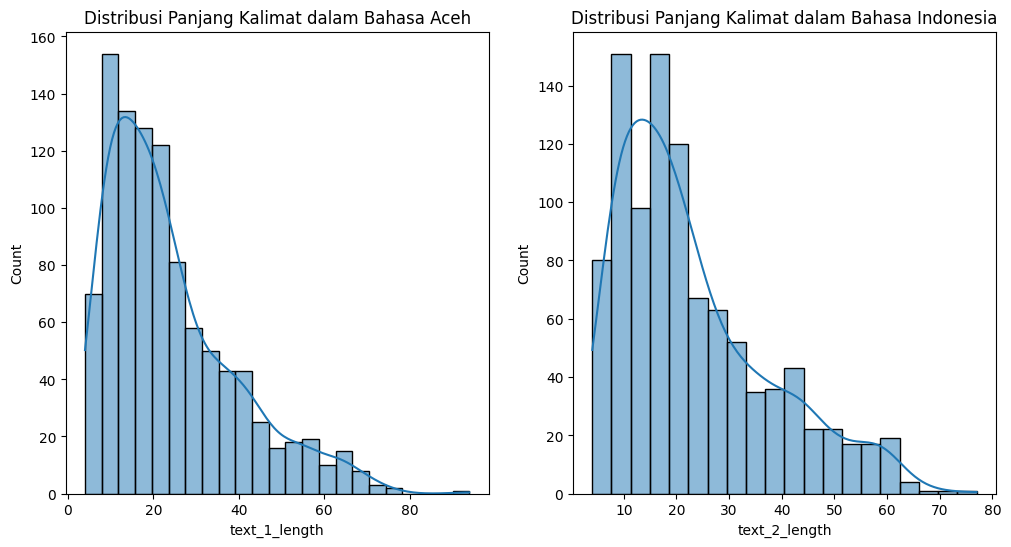

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.histplot(ace_ind_df['text_1_length'], kde=True)
plt.title('Distribusi Panjang Kalimat dalam Bahasa Aceh')

plt.subplot(1,2,2)
sns.histplot(ace_ind_df['text_2_length'], kde=True)
plt.title('Distribusi Panjang Kalimat dalam Bahasa Indonesia')

plt.show()


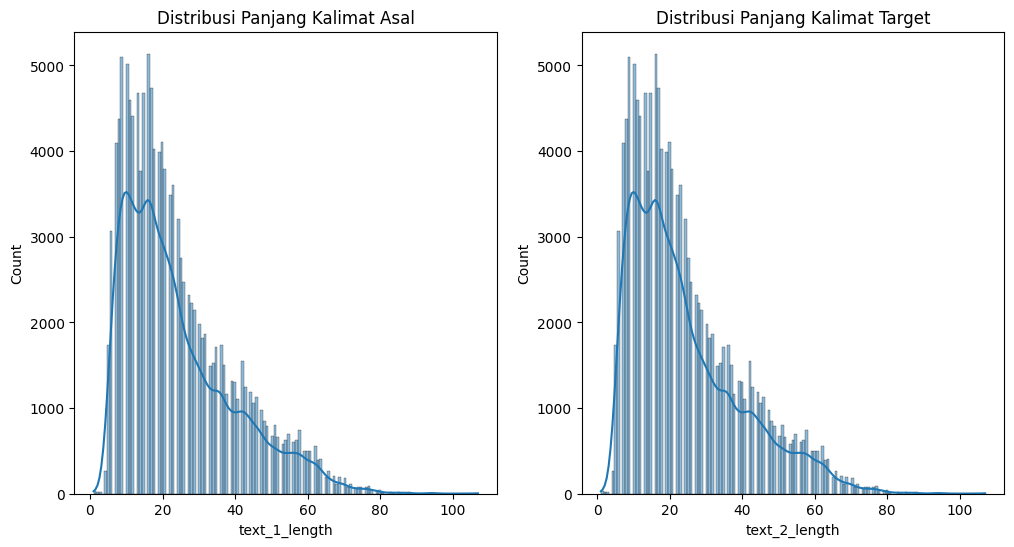

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.histplot(nusax_full_df['text_1_length'], kde=True)
plt.title('Distribusi Panjang Kalimat Asal')

plt.subplot(1,2,2)
sns.histplot(nusax_full_df['text_2_length'], kde=True)
plt.title('Distribusi Panjang Kalimat Target')

plt.show()


### Most Common Words

After that let see the most common words in each languaes using Counter From Collections Library. And After that we can also visualize it using Matplotlib and Seaborn

In [11]:
# kata kata paling umum
def get_most_common_words(series, n_most_common=10):
    counter = Counter()
    for sentence in series:
        counter.update(sentence.lower().split())
    return counter.most_common(n_most_common)

print("Kata-kata Paling Umum dalam Bahasa Aceh:")
print(get_most_common_words(ace_ind_df['text_1']))

print("\nKata-kata Paling Umum dalam Bahasa Indonesia:")
print(get_most_common_words(ace_ind_df['text_2']))

Kata-kata Paling Umum dalam Bahasa Aceh:
[('nyang', 596), ('ngon', 433), ('hana', 424), ('lon', 346), ('dan', 279), ('that', 277), ('bak', 276), ('di', 272), ('pih', 244), ('na', 237)]

Kata-kata Paling Umum dalam Bahasa Indonesia:
[('yang', 727), ('di', 545), ('dan', 541), ('tidak', 401), ('saya', 357), ('dengan', 299), ('untuk', 249), ('makan', 212), ('ini', 204), ('ke', 200)]


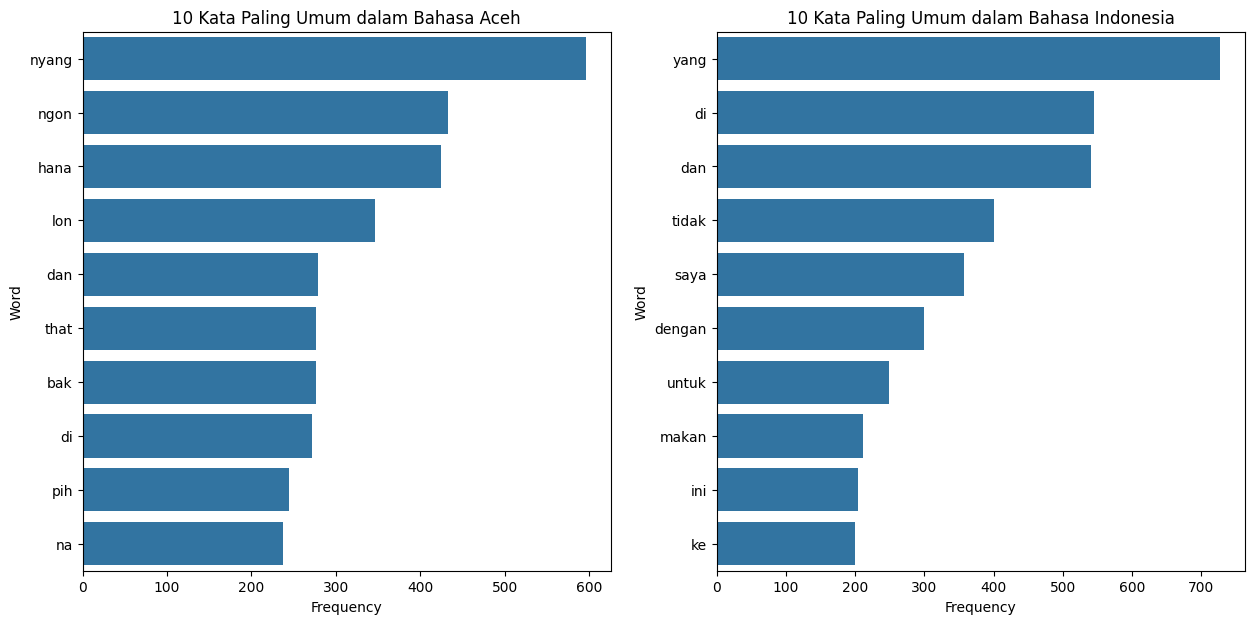

In [12]:
# Mendapatkan 10 kata teratas
top_sun_words = get_most_common_words(ace_ind_df['text_1'], 10)
top_eng_words = get_most_common_words(ace_ind_df['text_2'], 10)

# Membuat dataframe untuk visualisasi
df_vis_sun = pd.DataFrame(top_sun_words, columns=['Word', 'Frequency'])
df_vis_eng = pd.DataFrame(top_eng_words, columns=['Word', 'Frequency'])

# Visualisasi
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
sns.barplot(x='Frequency', y='Word', data=df_vis_sun)
plt.title('10 Kata Paling Umum dalam Bahasa Aceh')

plt.subplot(1,2,2)
sns.barplot(x='Frequency', y='Word', data=df_vis_eng)
plt.title('10 Kata Paling Umum dalam Bahasa Indonesia')

plt.show()

### N-Grams Analysis

We also can check the most common words using N-Grams function in this below code cell

In [13]:
def generate_ngrams(text, n=2):
    words = text.split()
    ngrams = zip(*[words[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

# Contoh untuk bigram dalam Bahasa Aceh
sun_bigrams = generate_ngrams(" ".join(ace_ind_df['text_1']), n=2)
display(Counter(sun_bigrams).most_common(10))

print('#'*20)

# Contoh untuk bigram dalam Bahasa Indonesia
eng_bigrams = generate_ngrams(" ".join(ace_ind_df['text_2']), n=2)
display(Counter(eng_bigrams).most_common(10))

[('pajoh bu', 37),
 ('hana that', 37),
 ('jak u', 34),
 ('makanan nyang', 33),
 ('jeuet keu', 29),
 ('nyang ka', 25),
 ('pih hana', 25),
 ('na di', 23),
 ('rumoh makan', 23),
 ('nyang hana', 22)]

####################


[('makan di', 44),
 ('di sini', 39),
 ('makanan yang', 33),
 ('tidak ada', 31),
 ('ke sini', 30),
 ('tidak terlalu', 30),
 ('enak dan', 29),
 ('tempat ini', 28),
 ('yang sangat', 27),
 ('di tempat', 25)]

In [14]:
# Contoh untuk trigram dalam Bahasa Aceh
sun_trigrams = generate_ngrams(" ".join(ace_ind_df['text_1']), n=3)
display(Counter(sun_bigrams).most_common(10))

print('#'*20)

# Contoh untuk trigram dalam Bahasa Indonesia
eng_trigrams = generate_ngrams(" ".join(ace_ind_df['text_2']), n=3)
display(Counter(eng_bigrams).most_common(10))

[('pajoh bu', 37),
 ('hana that', 37),
 ('jak u', 34),
 ('makanan nyang', 33),
 ('jeuet keu', 29),
 ('nyang ka', 25),
 ('pih hana', 25),
 ('na di', 23),
 ('rumoh makan', 23),
 ('nyang hana', 22)]

####################


[('makan di', 44),
 ('di sini', 39),
 ('makanan yang', 33),
 ('tidak ada', 31),
 ('ke sini', 30),
 ('tidak terlalu', 30),
 ('enak dan', 29),
 ('tempat ini', 28),
 ('yang sangat', 27),
 ('di tempat', 25)]

### WordClouds

We can also visualize the most common words in the datasets from each languages using WordClouds library.

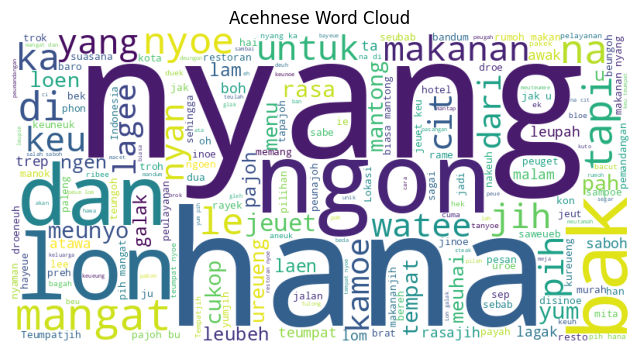

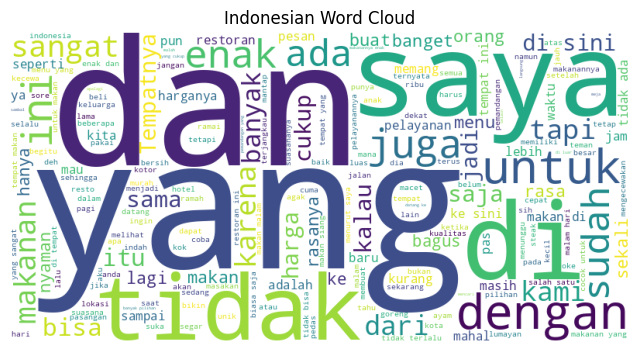

In [15]:
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(" ".join(text))
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_word_cloud(ace_ind_df['text_1'], 'Acehnese Word Cloud')
plot_word_cloud(ace_ind_df['text_2'], 'Indonesian Word Cloud')


# Texts Preprocessing

In [16]:
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

# Function to preprocess text
def preprocess_text(text, stopwords_list):
    # Convert text to lower case
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    words = text.split()
    # filtered_words = [word for word in words if word not in stopwords_list]

    # Remove double spaces
    text = ' '.join(
        words
        # filtered_words
        )

    return text

javanese_stopwords = set([
    "is", "the", "and", "to", "a", "of", "it", "in"
])

sundanese_stopwords = set([
    "di", "dan", "yang", "nu", "ka", "ku"
])

# preprocesed_df = ace_ind_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
# ace_ind_df['text_1'] = ace_ind_df['text_1'].apply(lambda x: preprocess_text(x, sundanese_stopwords))
# ace_ind_df['text_2'] = ace_ind_df['text_2'].apply(lambda x: preprocess_text(x, javanese_stopwords))

#### Check the Datasets again after text preprocessing

In [18]:
display(ace_ind_df)

,id,text_1,text_2,text_1_lang,text_2_lang,text_1_length,text_2_length
0,0,Neumeuseunang ngon neubayeue bacut-bacut angsu...,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,ace,ind,21,16
1,1,Kueh nyang dihidang peuingat lon masa dilee. B...,Kue-kue yang disajikan bikin saya bernostalgia...,ace,ind,22,22
2,2,Ibu tom geukereuja bak Grab Indonesia,Ibu pernah bekerja di grab indonesia,ace,ind,6,6
3,3,"Paleng galak ta pajoh bu leuho inoe, manok ngo...",Paling suka banget makan siang di sini ayam sa...,ace,ind,63,57
4,4,Peulayanan bus DAMRI cukop get,Pelayanan bus DAMRI sangat baik,ace,ind,5,5
...,...,...,...,...,...,...,...
995,95,Tulong neubi info atm toh mantong yang na di S...,Mohon informasikan atm mana saja di semarang y...,ace,ind,19,17
996,96,Rakan geurekomendasi teumpat nyoe saweueb rasa...,Teman merekomendasikan tempat ini karena rasa ...,ace,ind,37,37
997,97,"Phon keunoe lon peu sepele, pah watee loen deu...","Pertama ke sini saya under estimate, pas waktu...",ace,ind,42,42
998,98,Teumpatjih mangat keu nyang ka meukeuluarga at...,Tempatnya menyenangkan baik untuk yang sudah b...,ace,ind,38,42


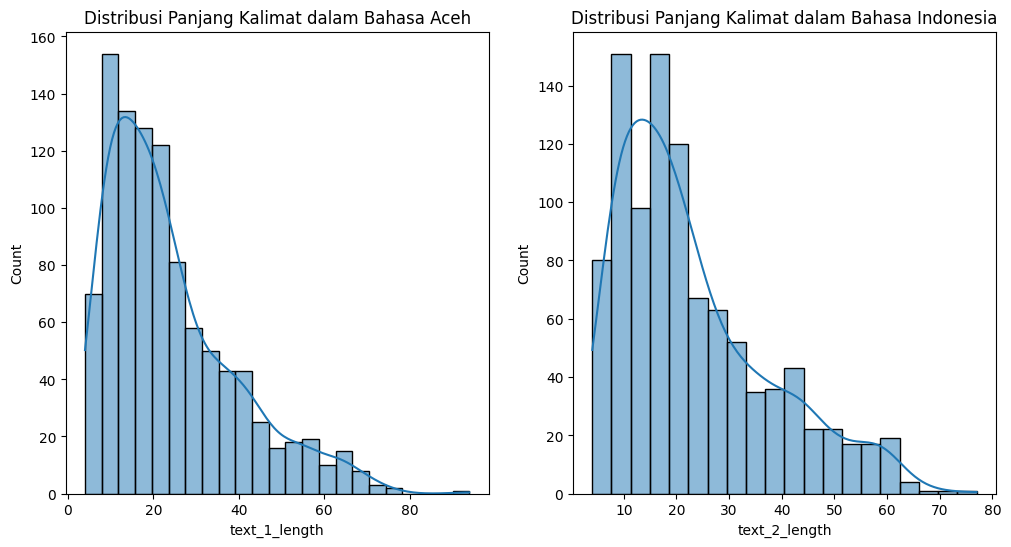

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.histplot(ace_ind_df['text_1_length'], kde=True)
plt.title('Distribusi Panjang Kalimat dalam Bahasa Aceh')

plt.subplot(1,2,2)
sns.histplot(ace_ind_df['text_2_length'], kde=True)
plt.title('Distribusi Panjang Kalimat dalam Bahasa Indonesia')

plt.show()


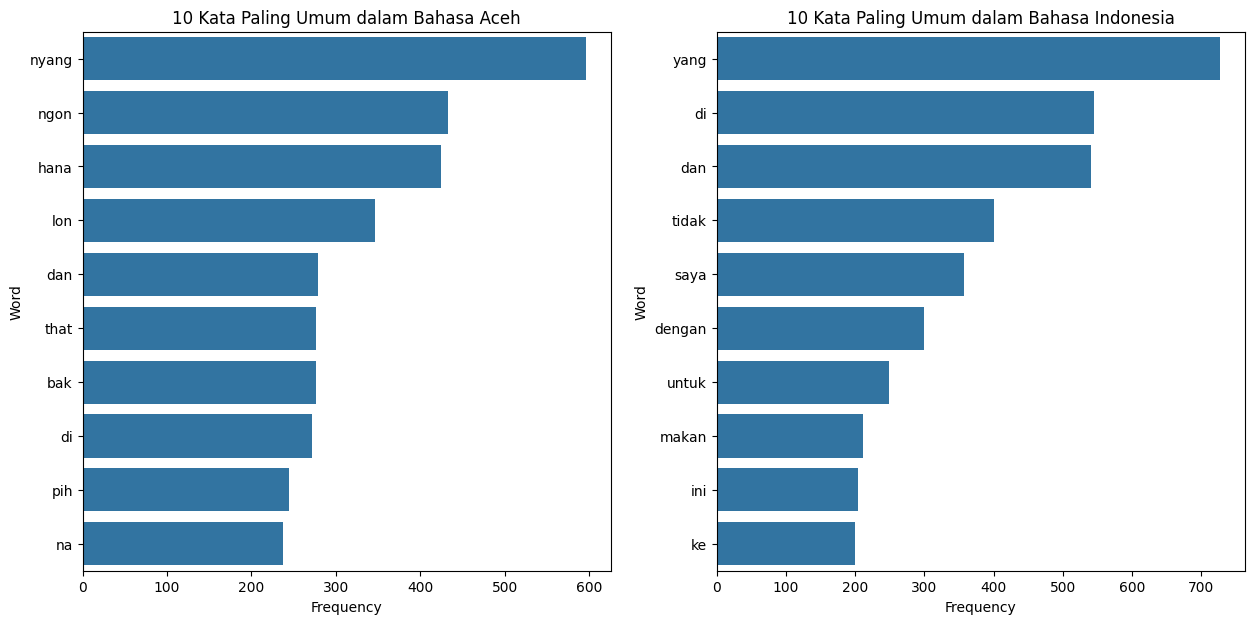

In [20]:
# Mendapatkan 10 kata teratas
top_sun_words = get_most_common_words(ace_ind_df['text_1'], 10)
top_eng_words = get_most_common_words(ace_ind_df['text_2'], 10)

# Membuat dataframe untuk visualisasi
df_vis_sun = pd.DataFrame(top_sun_words, columns=['Word', 'Frequency'])
df_vis_eng = pd.DataFrame(top_eng_words, columns=['Word', 'Frequency'])

# Visualisasi
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
sns.barplot(x='Frequency', y='Word', data=df_vis_sun)
plt.title('10 Kata Paling Umum dalam Bahasa Aceh')

plt.subplot(1,2,2)
sns.barplot(x='Frequency', y='Word', data=df_vis_eng)
plt.title('10 Kata Paling Umum dalam Bahasa Indonesia')

plt.show()

In [21]:
print("BIGRAMS")
# Contoh untuk bigram dalam Bahasa Aceh
sun_bigrams = generate_ngrams(" ".join(ace_ind_df['text_1']), n=2)
display(Counter(sun_bigrams).most_common(10))

print('#'*20)

# Contoh untuk bigram dalam Bahasa Indonesia
eng_bigrams = generate_ngrams(" ".join(ace_ind_df['text_2']), n=2)
display(Counter(eng_bigrams).most_common(10))

print('#'*25)

print("TRIGRAMS")
# Contoh untuk trigram dalam Bahasa Aceh
sun_trigrams = generate_ngrams(" ".join(ace_ind_df['text_1']), n=3)
display(Counter(sun_bigrams).most_common(10))

print('#'*20)

# Contoh untuk trigram dalam Bahasa Indonesia
eng_trigrams = generate_ngrams(" ".join(ace_ind_df['text_2']), n=3)
display(Counter(eng_bigrams).most_common(10))

BIGRAMS


[('pajoh bu', 37),
 ('hana that', 37),
 ('jak u', 34),
 ('makanan nyang', 33),
 ('jeuet keu', 29),
 ('nyang ka', 25),
 ('pih hana', 25),
 ('na di', 23),
 ('rumoh makan', 23),
 ('nyang hana', 22)]

####################


[('makan di', 44),
 ('di sini', 39),
 ('makanan yang', 33),
 ('tidak ada', 31),
 ('ke sini', 30),
 ('tidak terlalu', 30),
 ('enak dan', 29),
 ('tempat ini', 28),
 ('yang sangat', 27),
 ('di tempat', 25)]

#########################
TRIGRAMS


[('pajoh bu', 37),
 ('hana that', 37),
 ('jak u', 34),
 ('makanan nyang', 33),
 ('jeuet keu', 29),
 ('nyang ka', 25),
 ('pih hana', 25),
 ('na di', 23),
 ('rumoh makan', 23),
 ('nyang hana', 22)]

####################


[('makan di', 44),
 ('di sini', 39),
 ('makanan yang', 33),
 ('tidak ada', 31),
 ('ke sini', 30),
 ('tidak terlalu', 30),
 ('enak dan', 29),
 ('tempat ini', 28),
 ('yang sangat', 27),
 ('di tempat', 25)]

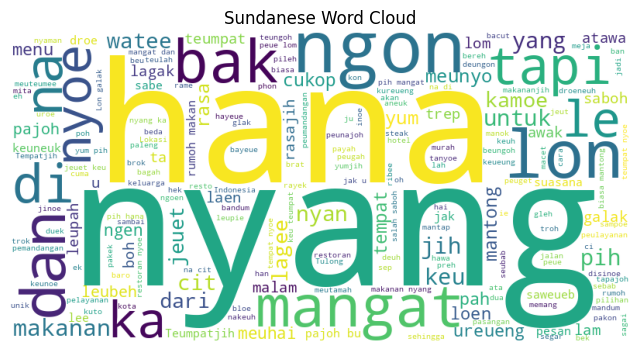

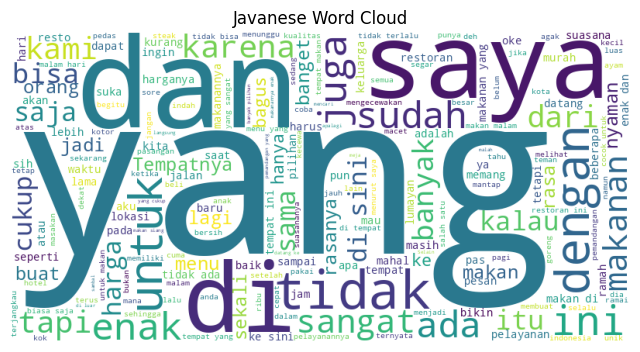

In [22]:
plot_word_cloud(ace_ind_df['text_1'], 'Sundanese Word Cloud')
plot_word_cloud(ace_ind_df['text_2'], 'Javanese Word Cloud')

# Datasets Preprocessing

In [23]:
nusax_AcehInd = DatasetHF.from_pandas(ace_ind_df)

display(nusax_AcehInd)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 1000
})

In [24]:
# Split the dataset into training, validation, and test sets
split_ratios = [0.8, 0.1, 0.1]  # 80% training, 10% validation, 10% test
split_names = ['train', 'validation', 'test']

splits = nusax_AcehInd.train_test_split(test_size=0.2)
train_dataset, valid_test_dataset = splits['train'], splits['test']

splits = valid_test_dataset.train_test_split(test_size=0.5)
valid_dataset, test_dataset = splits['train'], splits['test']

display(train_dataset)
display(test_dataset)
display(valid_dataset)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 800
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 100
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 100
})

In [25]:
checkpoint = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(checkpoint)

source_lang = 'sun'
target_lang = 'ind'
prefix = "Translate Acehnese to Indonesian: "

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The preprocessing function you want to create needs to:

1. Prefix the input with a prompt so T5 knows this is a translation task. Some models capable of multiple NLP tasks require prompting for specific tasks.
2. Tokenize the input (Sundanese) and target (English) separately because you can't tokenize French text with a tokenizer pretrained on an English vocabulary.
3. Truncate sequences to be no longer than the maximum length set by the `max_length` parameter.

To apply the preprocessing function over the entire dataset, use 🤗 Datasets [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) method. You can speed up the `map` function by setting `batched=True` to process multiple elements of the dataset at once:

In [26]:
def preprocess_function(examples):
    inputs = [prefix + src for src in examples["text_1"]]
    targets = examples["text_2"]
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length", return_tensors="pt")

    # Prepare decoder_input_ids
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=256, truncation=True, padding="max_length", return_tensors="pt")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenized_nusax_train = train_dataset.map(preprocess_function, batched=True)
tokenized_nusax_test = test_dataset.map(preprocess_function, batched=True)
tokenized_nusax_valid = valid_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [27]:
display(tokenized_nusax_train)
display(tokenized_nusax_test)
display(tokenized_nusax_valid)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 800
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})

In [28]:
tokenized_nusax_train['input_ids'][:1]

[[30355,
  15,
  16475,
  12836,
  7,
  15,
  12,
  9995,
  29,
  10,
  16663,
  1468,
  12674,
  1725,
  3,
  1050,
  76,
  565,
  210,
  9,
  3,
  29,
  9,
  1050,
  76,
  107,
  3,
  210,
  342,
  15,
  158,
  440,
  603,
  3180,
  3,
  2618,
  6680,
  15,
  17,
  3,
  354,
  23,
  855,
  8371,
  26,
  9,
  44,
  7396,
  3,
  2618,
  9,
  2277,
  60,
  83,
  15,
  15,
  3,
  17,
  15,
  413,
  15,
  76,
  15,
  12,
  107,
  5854,
  1478,
  9,
  3877,
  12,
  107,
  1977,
  24101,
  23,
  3,
  2729,
  235,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [29]:
tokenized_nusax_train['attention_mask'][:1]

[[1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


Now create a batch of examples using [DataCollatorForSeq2Seq](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorForSeq2Seq). It's more efficient to *dynamically pad* the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [30]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [31]:
import evaluate

# Load metrics
sacrebleu_metric = evaluate.load("sacrebleu")
meteor_metric = evaluate.load("meteor")
bertscore_metric = evaluate.load("bertscore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


compute metrics function

In [32]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # Initialize result dictionary
    result = {}

    # Calculate accuracy
    # total = len(decoded_labels)
    # correct = sum(pred == label[0] for pred, label in zip(decoded_preds, decoded_labels))
    # accuracy = correct / total
    # result["accuracy"] = accuracy

    # Compute sacreBLEU
    bleu_result = sacrebleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    result["bleu"] = bleu_result["score"]

    # Compute METEOR
    meteor_result = meteor_metric.compute(predictions=decoded_preds, references=decoded_labels)
    result["meteor"] = meteor_result["meteor"]

    # Compute BERTScore
    bertscore_result = bertscore_metric.compute(predictions=decoded_preds, references=decoded_labels, lang="en")
    result["bertscore_precision"] = np.mean(bertscore_result["precision"])
    result["bertscore_recall"] = np.mean(bertscore_result["recall"])
    result["bertscore_f1"] = np.mean(bertscore_result["f1"])

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}

    return result


In [33]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

training arguments

In [34]:
training_args = Seq2SeqTrainingArguments(
    output_dir="T5_NusaX_Ace_Ind_checkpoints",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=5,
    num_train_epochs=100,
    predict_with_generate=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_nusax_train,
    eval_dataset=tokenized_nusax_valid,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Meteor,Bertscore Precision,Bertscore Recall,Bertscore F1,Gen Len
1,No log,1.381551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,No log,1.223774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,No log,1.138386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,No log,1.087331,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,No log,1.048095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,No log,1.019173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,No log,0.995085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,No log,0.976019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,No log,0.957863,0.000000,0.001600,0.025500,0.022900,0.024100,0.570000
10,1.511900,0.942255,0.000300,0.017900,0.279200,0.257600,0.267900,6.270000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) 

TrainOutput(global_step=5000, training_loss=0.8350839477539063, metrics={'train_runtime': 2246.2056, 'train_samples_per_second': 35.616, 'train_steps_per_second': 2.226, 'total_flos': 5413672058880000.0, 'train_loss': 0.8350839477539063, 'epoch': 100.0})

In [35]:
model_name = "T5_NusaX_Ace_Ind_model"
trainer.save_model(model_name)

# Predict Evaluate

### Inference

Great, now that you've finetuned a model, you can use it for inference!

Come up with some text you'd like to translate to another language. For T5, you need to prefix your input depending on the task you're working on. For translation from English to French, you should prefix your input as shown below:

In [36]:
from transformers import pipeline

source = "Translate Acehnese to Indonesian: Upami anjeun ngagaduhan patarosan deui hoyong terang atanapi ngalaman masalah anu aya hubunganana sareng produk Traveloka, tong ragu ngahubungi kami deui."
# label = "If you have further questions you'd like to ask, or have issues regarding Traveloka's products, be sure to contact us again."

translator = pipeline("translation", model=model_name)
translator(source)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/__init__.py:1049: UserWarning: "translation" task was used, instead of "translation_XX_to_YY", defaulting to "translation_en_to_de"
  warnings.warn(


[{'translation_text': 'Upami anjeun ngagaduhan patarosan deui terang atanapi ngalaman masalah anu aya hubunganana sareng produk traveloka, tong ragu ngahubungi kami deui.'}]

In [37]:

def predict_evaluate(data):
    try:
        sources = data['text_1']
        targets = data['text_2']

        predictions = [translator(prefix + source)[0]['translation_text'] for source in sources]

        # Initialize lists to store results
        predicts, accuracies, bleus, meteors, bertscore_precisions, bertscore_recalls, bertscore_f1s = [], [], [], [], [], [], []

        for prediction, target in zip(predictions, targets):
            predicts.append(prediction)

            # Calculate accuracy for each prediction
            # accuracies.append(int(prediction == target))

            # Compute sacreBLEU
            bleu_result = sacrebleu_metric.compute(predictions=[prediction], references=[target])
            bleus.append(bleu_result["score"])

            # Compute METEOR
            meteor_result = meteor_metric.compute(predictions=[prediction], references=[target])
            meteors.append(meteor_result["meteor"])

            # Compute BERTScore
            bertscore_result = bertscore_metric.compute(predictions=[prediction], references=[target], lang="en")
            bertscore_precisions.append(bertscore_result["precision"])
            bertscore_recalls.append(bertscore_result["recall"])
            bertscore_f1s.append(bertscore_result["f1"])

        # Return a dictionary with lists as values
        return {
            "input": data['text_1'],
            "predict": predicts,
            "target": targets,
            # "accuracy": accuracies,  # Now a list of accuracies
            "bleu": bleus,
            "meteor": meteors,
            "bertscore_precision": bertscore_precisions,
            "bertscore_recall": bertscore_recalls,
            "bertscore_f1": bertscore_f1s
        }

    except Exception as e:
        print(f"Error during prediction or evaluation: {e}")
        return None

# Assuming test_dataset is correctly defined
data_test_predict_eval = test_dataset.map(predict_evaluate, batched=True)



Parameter 'function'=<function predict_evaluate at 0x7bd53fff4af0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Your input_length: 289 is bigger than 0.9 * max_length: 300. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


In [38]:
predict_eval_df = data_test_predict_eval.to_pandas()

display(predict_eval_df.drop(['text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length',], axis=1))

,id,input,predict,target,bleu,meteor,bertscore_precision,bertscore_recall,bertscore_f1
0,411,Makanan inoe mangat keuh. Leubeh mangat daripa...,Makanan ini membuat ini. Lebih daripada tempat...,Makanan di sini enak loh. Lebih enak ketimbang...,10.577541,0.320873,[0.9031164050102234],[0.883743405342102],[0.8933249115943909]
1,476,Restoran ngen pemandangan yang meunawan meskip...,Restoran dengan pemandangan yang menikpun haru...,Restoran dengan pemandangan yang menawan meski...,26.047915,0.576484,[0.9563789367675781],[0.9261333346366882],[0.9410131573677063]
2,477,"Steak nyang beutoi-beutoi steak, peue lom chic...",Tempat yang tidak - tidak bulejih yang tidak r...,Steak sebenar-benarnya steak especially chiken...,1.420698,0.115405,[0.7756161093711853],[0.812955915927887],[0.7938471436500549]
3,144,"Meunyo disinoe siejih leubeh mangat, bumbu leu...","Saya di sini saja enak, bumbu saja yang ada id...","Kalau di sini dagingnya lebih enak, bumbunya s...",6.859315,0.335742,[0.9174460172653198],[0.8714825510978699],[0.8938738107681274]
4,290,Nyoe ndihome lon na gangguan lom. Lon teungoh ...,Saya ndihome ada gangguan saja. Saya tiba tiba...,Ini indihome saya gangguan lagi ini. Saya lagi...,5.421654,0.265352,[0.8686394691467285],[0.8492203950881958],[0.8588201999664307]
...,...,...,...,...,...,...,...,...,...
95,339,"Lagee nyang dipeusaran, lon cuba mie gureng sp...","Ayam yang dipeusaran, tidak bersial dan rasany...","Sesuai rekomendasi, saya mencoba mie goreng sp...",6.125742,0.293564,[0.8592879772186279],[0.832473874092102],[0.845668375492096]
96,55,Kupat tahu gempol nakeuh salah saboh kupat tah...,Tempatnya tidak tidak saja kupat tidak yang be...,Kupat tahu gempol merupakan salah satu kupat t...,2.509808,0.100167,[0.867035984992981],[0.8153254389762878],[0.8403860330581665]
97,292,"Pah untuk duek pakat, walimah, poto-poto. Suas...","Tempat pakat, walimah, poto-poto. Suasanajih t...","Cocok buat pertemuan, acara pernikahan, pemotr...",18.302962,0.441726,[0.8825302124023438],[0.8769901990890503],[0.8797515034675598]
98,183,"Assalamualaikom. Wah, brat kecewa sebab indiho...","Assalamualaikom. Wah, brat kecewa sebab indiho...",Selamat pagi. Wah kecewa berat masa indihome i...,5.872253,0.278728,[0.898898720741272],[0.8942788243293762],[0.8965827822685242]


In [39]:
display(predict_eval_df[:1]['predict'])
display(predict_eval_df[:1]['target'])

0    Makanan ini membuat ini. Lebih daripada tempat...
Name: predict, dtype: object

0    Makanan di sini enak loh. Lebih enak ketimbang...
Name: target, dtype: object

In [40]:
predict_eval_df['bleu'].mean()

9.00106078509689

In [41]:
predict_eval_df['meteor'].mean()

0.2804979481137216

# Datasets
- https://huggingface.co/datasets/indonlp/NusaX-MT
- https://github.com/IndoNLP/nusax
- https://ar5iv.labs.arxiv.org/html/2205.15960

# References

- https://github.com/huggingface/transformers/tree/main/examples/pytorch/translation
- https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/translation.ipynb#scrollTo=X4cRE8IbIrIV
- https://huggingface.co/docs/transformers/tasks/translation
- https://huggingface.co/docs/transformers/model_doc/t5
- https://github.com/EliasK93/transformer-models-for-domain-specific-machine-translation
- https://huggingface.co/docs/transformers/model_doc/marian#old-style-multi-lingual-models